<a href="https://colab.research.google.com/github/Giuliafranchi1/Algorithm_massivedata/blob/master/CORRETTO_FRANCHI_PROJECT1pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
from torch import nn
import os
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
from tqdm import tqdm

#reproducibility
seed=1
np.random.seed(seed)
random.seed(seed)
t.manual_seed(seed)
# for cuda
t.cuda.manual_seed_all(seed)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
t.backends.cudnn.enabled = False
os.environ['PYTHONHASHSEED'] = str(seed)

#set GPU
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
#Import dataset from Kaggle

!mkdir -p /root/.kaggle
!echo '{"username":"giuliafranchi","key":"4cfe8adf4b6fb74cc4f72ff3a92f971f"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.56G/6.56G [01:30<00:00, 91.1MB/s]
100% 6.56G/6.56G [01:30<00:00, 77.7MB/s]


In [ ]:
!unzip plant-leaves-for-image-classification.zip

## Pre-processing

In [ ]:
#access to the folder of imgs and labels
img_names = np.array(list(glob('./Plants_2/*/*/*')))

loaded_imgs = [] #images
loaded_labels = [] #names of plants species
loaded_modes = [] #train/valid/test
print(f"{len(img_names)=}") #4494
for img_name in tqdm(img_names):

  img = np.array(
      Image.open(img_name).convert('L') #grey scale from PIL library
  )
  resize_factor = 30
  new_shape = (np.array(img.shape) / resize_factor).astype(int)
  img_resized = resize(img, new_shape)
  img_cropped = img_resized[
      400// resize_factor:-400//resize_factor, #width 200-2*13.34 x-axis
      400//resize_factor:-400//resize_factor #height 133-2*13.34 y-axis
  ]
  img = img_cropped
  img = t.from_numpy(img) #convert img into tensor
  
  label = img_name.split('/')[-2].split(' ')[0] #plant name
  mode = img_name.split('/')[2] #train/valid/test
  loaded_imgs.append(img)
  loaded_labels.append(label)
  #if mode != 'train':
    #print(mode)
  loaded_modes.append(mode)

len(img_names)=0


0it [00:00, ?it/s]


In [ ]:
#divide each label and trasform from string into integer number 
unique_labels = list(set(loaded_labels))
numerical_labels = []
for label in loaded_labels:
    numerical_labels.append(
        unique_labels.index(label)
    )
numerical_labels = t.tensor(numerical_labels) #convert into tensor


# separate in train/test/valid/images to predict
unique_modes = list(set(loaded_modes))

print(f"Train: {len([l for l in loaded_modes if l == 'train'])}") #4274
print(f"Test: {len([l for l in loaded_modes if l == 'test'])}") #110
print(f"Valid: {len([l for l in loaded_modes if l == 'valid'])}") #110


dataloaders = {}
for mode in unique_modes:
  mask = np.array([m == mode for m in loaded_modes]) # boolean list transformed into numpy array
  labels = numerical_labels[mask]
  imgs = t.stack([loaded_imgs[i] for i in range(len(mask)) if mask[i]]) 
  # create dataset
  dataset = t.utils.data.TensorDataset(imgs, labels)
  # create dataloader + specify batch size + shuffle=True 
  dataloader = t.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
  dataloaders[mode] = dataloader

print(dataloaders)

Train: 4274
Test: 110
Valid: 110
{'test': <torch.utils.data.dataloader.DataLoader object at 0x7fc90212c460>, 'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc90212cbb0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7fc90212c430>}


In [ ]:
train_dataloader = dataloaders['train']

for batch_imgs, batch_labels in train_dataloader:
 print(batch_imgs.shape) # shape = [64, 106, 173]
 print(batch_labels.shape) # shape = [64]
 break

torch.Size([64, 106, 173])
torch.Size([64])


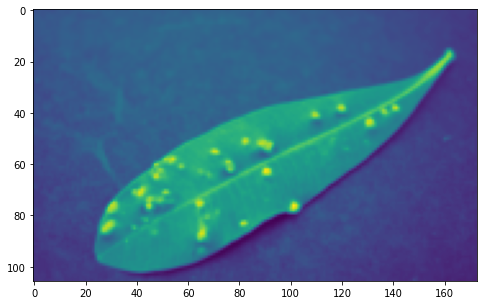

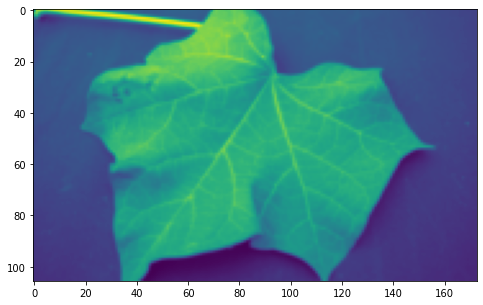

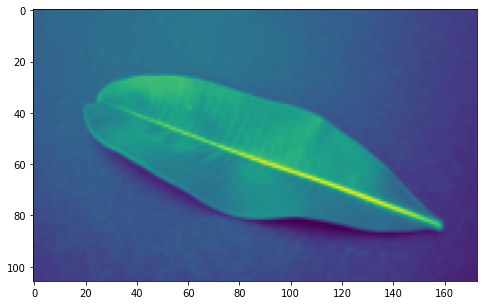

In [ ]:
#show one img for each mode: train, test, valid
plt.rcParams['figure.figsize'] = [10, 5]
for imgs, labels in dataloaders['train']:
  plt.imshow(imgs[0])
  plt.show()
  break

for imgs, labels in dataloaders['test']:
  plt.imshow(imgs[0])
  plt.show()
  break

for imgs, labels in dataloaders['valid']:
  plt.imshow(imgs[0])
  plt.show()
  break

## Model for my neural network

In [ ]:
try:
  from torchsummary import summary
except:
  !pip install torch-summary
  from torchsummary import summary

#general structure of my model
def conv_block(in_c, out_c, k=3, pad=1):
    return nn.Sequential(
        nn.BatchNorm2d(in_c),
        nn.Conv2d(
            in_c,
            out_c,
            k,
            padding=pad,
            bias=False 
        ), 
        nn.MaxPool2d(2), 
        nn.ReLU()
    )

def get_model(first_layer_kernel_size, dropout_rate):
  return nn.Sequential(
        conv_block(1, 16, first_layer_kernel_size), 
        conv_block(16, 32),
        conv_block(32, 64),
        conv_block(64, 128),
        conv_block(128, 256),
        nn.Flatten(),  
        nn.Linear(3840, 256),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(256, 12),
        nn.Softmax(1)
  ).to(device) 


## Hyperparemeter Tuning & Model Selection

In [ ]:
def train_single_epoch(*, optim, loss_fn, model):
  tot_loss = 0
  n_imgs = 0
  for img, label in tqdm(dataloaders['train']):
    label = label.to(device)
    batch_size = img.shape[0]
    img = img.to(device)
    optim.zero_grad()
    img = (img[:, None] / 255).float() #normalization of imgs-> pixels 0-255
    pred_label = model(img)
    loss = loss_fn(pred_label, label) 
    loss.backward()
    optim.step() 
    tot_loss += loss.item()
    n_imgs += batch_size
  return (tot_loss / n_imgs)

  
def test_or_valid(*, dataloader, model):
  loss_fn = t.nn.CrossEntropyLoss()
  with t.no_grad():
    tot_loss = 0
    n_imgs = 0
    correct_preds = 0 
    for batch_imgs, batch_labels in tqdm(dataloader):
      batch_labels = batch_labels.to(device)
      batch_imgs = batch_imgs.to(device)
      batch_size = batch_imgs.shape[0]
      batch_imgs = (
          batch_imgs[:, None]/ 255 #normalization of imgs-> pixels 0-255
      ).float()
      pred_batch_labels = model(batch_imgs)
      pred_batch_class = t.argmax(pred_batch_labels, dim=1)
      correct_preds += (pred_batch_class == batch_labels).sum().item()
      loss = loss_fn(pred_batch_labels, batch_labels)
      tot_loss += loss.item()
      n_imgs += batch_size

    mean_loss = tot_loss / n_imgs
    accuracy = correct_preds / n_imgs

  return mean_loss, accuracy

def train(*, lr, n_epochs, first_layer_kernel_size, dropout_rate, plot=False): 
  model = get_model(first_layer_kernel_size, dropout_rate )
  if plot:
    summary(model, (1, 106, 173))
  optim = t.optim.Adam(model.parameters(), lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  train_losses = []
  val_losses = []
  val_accs = []
  for epoch in range(n_epochs):
      train_loss = train_single_epoch(
        model=model,
        loss_fn=loss_fn,
        optim=optim
      )
      val_loss, val_acc = test_or_valid(
        dataloader=dataloaders['valid'],
        model=model,
      ) #testing
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      if plot:
        print(
          f"\nEpoch: {epoch}, train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )


  if plot:
    #plotting
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(t.arange(n_epochs), train_losses, label='train_loss')
    axes[0].plot(t.arange(n_epochs), val_losses, label='val_loss')
    axes[0].legend()
    axes[1].plot(t.arange(n_epochs), val_accs, label='val_accuracy')
    axes[1].legend()
    plt.show()
  return val_acc, model


In [ ]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

def objective(trial):
    first_layer_kernel_size = trial.suggest_int('first_layer_kernel_size', 1, 5)
    lr = trial.suggest_float('lr', 0.0001, 0.001)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    val_acc, _ = train(
      lr=lr,
      first_layer_kernel_size=first_layer_kernel_size,
      dropout_rate=dropout_rate,
      n_epochs=1
    )
    return val_acc 

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed)) 
study.optimize(
    objective,
    n_trials=20
)


In [ ]:
study.best_params

{'first_layer_kernel_size': 2,
 'lr': 0.00023208030173540176,
 'dropout_rate': 0.13693543790751914}

## Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 106, 173]               2
            Conv2d-2         [-1, 16, 107, 174]              64
         MaxPool2d-3           [-1, 16, 53, 87]               0
              ReLU-4           [-1, 16, 53, 87]               0
       BatchNorm2d-5           [-1, 16, 53, 87]              32
            Conv2d-6           [-1, 32, 53, 87]           4,608
         MaxPool2d-7           [-1, 32, 26, 43]               0
              ReLU-8           [-1, 32, 26, 43]               0
       BatchNorm2d-9           [-1, 32, 26, 43]              64
           Conv2d-10           [-1, 64, 26, 43]          18,432
        MaxPool2d-11           [-1, 64, 13, 21]               0
             ReLU-12           [-1, 64, 13, 21]               0
      BatchNorm2d-13           [-1, 64, 13, 21]             128
           Conv2d-14          [-1, 128,

100%|██████████| 2/2 [00:00<00:00, 68.67it/s]



Epoch: 0, train_loss=0.0340 val_loss=0.0401 val_acc=0.4091


100%|██████████| 2/2 [00:00<00:00, 69.71it/s]



Epoch: 1, train_loss=0.0315 val_loss=0.0375 val_acc=0.5455


100%|██████████| 2/2 [00:00<00:00, 70.36it/s]



Epoch: 2, train_loss=0.0298 val_loss=0.0364 val_acc=0.6182


100%|██████████| 2/2 [00:00<00:00, 66.50it/s]



Epoch: 3, train_loss=0.0294 val_loss=0.0364 val_acc=0.6273


100%|██████████| 2/2 [00:00<00:00, 73.17it/s]



Epoch: 4, train_loss=0.0290 val_loss=0.0367 val_acc=0.6091


100%|██████████| 2/2 [00:00<00:00, 70.32it/s]



Epoch: 5, train_loss=0.0287 val_loss=0.0369 val_acc=0.5909


100%|██████████| 2/2 [00:00<00:00, 70.23it/s]



Epoch: 6, train_loss=0.0287 val_loss=0.0362 val_acc=0.6364


100%|██████████| 2/2 [00:00<00:00, 62.68it/s]



Epoch: 7, train_loss=0.0286 val_loss=0.0358 val_acc=0.6455


100%|██████████| 2/2 [00:00<00:00, 70.62it/s]



Epoch: 8, train_loss=0.0284 val_loss=0.0354 val_acc=0.6636


100%|██████████| 2/2 [00:00<00:00, 70.93it/s]



Epoch: 9, train_loss=0.0284 val_loss=0.0355 val_acc=0.6818


100%|██████████| 2/2 [00:00<00:00, 69.18it/s]



Epoch: 10, train_loss=0.0283 val_loss=0.0356 val_acc=0.6636


100%|██████████| 2/2 [00:00<00:00, 69.05it/s]



Epoch: 11, train_loss=0.0283 val_loss=0.0356 val_acc=0.6636


100%|██████████| 2/2 [00:00<00:00, 67.56it/s]



Epoch: 12, train_loss=0.0283 val_loss=0.0356 val_acc=0.6545


100%|██████████| 2/2 [00:00<00:00, 71.59it/s]



Epoch: 13, train_loss=0.0283 val_loss=0.0363 val_acc=0.6182


100%|██████████| 2/2 [00:00<00:00, 69.50it/s]



Epoch: 14, train_loss=0.0280 val_loss=0.0340 val_acc=0.7455


100%|██████████| 2/2 [00:00<00:00, 72.28it/s]



Epoch: 15, train_loss=0.0276 val_loss=0.0339 val_acc=0.7636


100%|██████████| 2/2 [00:00<00:00, 65.28it/s]



Epoch: 16, train_loss=0.0274 val_loss=0.0341 val_acc=0.7455


100%|██████████| 2/2 [00:00<00:00, 69.24it/s]



Epoch: 17, train_loss=0.0275 val_loss=0.0348 val_acc=0.7000


100%|██████████| 2/2 [00:00<00:00, 69.56it/s]



Epoch: 18, train_loss=0.0275 val_loss=0.0344 val_acc=0.7364


100%|██████████| 2/2 [00:00<00:00, 67.53it/s]



Epoch: 19, train_loss=0.0274 val_loss=0.0342 val_acc=0.7273


100%|██████████| 2/2 [00:00<00:00, 62.47it/s]



Epoch: 20, train_loss=0.0273 val_loss=0.0338 val_acc=0.7545


100%|██████████| 2/2 [00:00<00:00, 71.08it/s]



Epoch: 21, train_loss=0.0273 val_loss=0.0342 val_acc=0.7455


100%|██████████| 2/2 [00:00<00:00, 72.17it/s]



Epoch: 22, train_loss=0.0273 val_loss=0.0340 val_acc=0.7455


100%|██████████| 2/2 [00:00<00:00, 70.54it/s]



Epoch: 23, train_loss=0.0273 val_loss=0.0340 val_acc=0.7636


100%|██████████| 2/2 [00:00<00:00, 69.35it/s]



Epoch: 24, train_loss=0.0273 val_loss=0.0337 val_acc=0.7727


100%|██████████| 2/2 [00:00<00:00, 70.85it/s]



Epoch: 25, train_loss=0.0274 val_loss=0.0339 val_acc=0.7545


100%|██████████| 2/2 [00:00<00:00, 68.46it/s]



Epoch: 26, train_loss=0.0274 val_loss=0.0343 val_acc=0.7364


100%|██████████| 2/2 [00:00<00:00, 64.87it/s]



Epoch: 27, train_loss=0.0273 val_loss=0.0340 val_acc=0.7545


100%|██████████| 2/2 [00:00<00:00, 65.37it/s]



Epoch: 28, train_loss=0.0268 val_loss=0.0328 val_acc=0.8182


100%|██████████| 2/2 [00:00<00:00, 64.68it/s]



Epoch: 29, train_loss=0.0266 val_loss=0.0340 val_acc=0.7455


100%|██████████| 2/2 [00:00<00:00, 70.59it/s]



Epoch: 30, train_loss=0.0265 val_loss=0.0335 val_acc=0.7727


100%|██████████| 2/2 [00:00<00:00, 69.35it/s]



Epoch: 31, train_loss=0.0266 val_loss=0.0333 val_acc=0.7909


100%|██████████| 2/2 [00:00<00:00, 71.33it/s]



Epoch: 32, train_loss=0.0266 val_loss=0.0328 val_acc=0.8182


100%|██████████| 2/2 [00:00<00:00, 64.37it/s]



Epoch: 33, train_loss=0.0264 val_loss=0.0323 val_acc=0.8364


100%|██████████| 2/2 [00:00<00:00, 71.43it/s]



Epoch: 34, train_loss=0.0264 val_loss=0.0333 val_acc=0.7818


100%|██████████| 2/2 [00:00<00:00, 71.07it/s]



Epoch: 35, train_loss=0.0265 val_loss=0.0324 val_acc=0.8545


100%|██████████| 2/2 [00:00<00:00, 69.87it/s]



Epoch: 36, train_loss=0.0264 val_loss=0.0333 val_acc=0.8000


100%|██████████| 2/2 [00:00<00:00, 70.70it/s]



Epoch: 37, train_loss=0.0265 val_loss=0.0330 val_acc=0.7909


100%|██████████| 2/2 [00:00<00:00, 70.00it/s]



Epoch: 38, train_loss=0.0265 val_loss=0.0321 val_acc=0.8636


100%|██████████| 2/2 [00:00<00:00, 69.88it/s]



Epoch: 39, train_loss=0.0264 val_loss=0.0329 val_acc=0.8091


100%|██████████| 2/2 [00:00<00:00, 69.13it/s]



Epoch: 40, train_loss=0.0264 val_loss=0.0321 val_acc=0.8636


100%|██████████| 2/2 [00:00<00:00, 68.82it/s]



Epoch: 41, train_loss=0.0264 val_loss=0.0329 val_acc=0.8091


100%|██████████| 2/2 [00:00<00:00, 70.75it/s]



Epoch: 42, train_loss=0.0264 val_loss=0.0333 val_acc=0.7727


100%|██████████| 2/2 [00:00<00:00, 68.94it/s]



Epoch: 43, train_loss=0.0264 val_loss=0.0323 val_acc=0.8545


100%|██████████| 2/2 [00:00<00:00, 71.73it/s]



Epoch: 44, train_loss=0.0264 val_loss=0.0324 val_acc=0.8364


100%|██████████| 2/2 [00:00<00:00, 70.71it/s]



Epoch: 45, train_loss=0.0261 val_loss=0.0314 val_acc=0.9000


100%|██████████| 2/2 [00:00<00:00, 66.69it/s]



Epoch: 46, train_loss=0.0260 val_loss=0.0319 val_acc=0.8636


100%|██████████| 2/2 [00:00<00:00, 72.68it/s]



Epoch: 47, train_loss=0.0260 val_loss=0.0316 val_acc=0.8818


100%|██████████| 2/2 [00:00<00:00, 72.43it/s]



Epoch: 48, train_loss=0.0260 val_loss=0.0320 val_acc=0.8455


100%|██████████| 2/2 [00:00<00:00, 70.14it/s]



Epoch: 49, train_loss=0.0259 val_loss=0.0317 val_acc=0.8818


100%|██████████| 2/2 [00:00<00:00, 63.75it/s]



Epoch: 50, train_loss=0.0260 val_loss=0.0317 val_acc=0.8818


100%|██████████| 2/2 [00:00<00:00, 68.58it/s]



Epoch: 51, train_loss=0.0259 val_loss=0.0321 val_acc=0.8545


100%|██████████| 2/2 [00:00<00:00, 71.38it/s]



Epoch: 52, train_loss=0.0259 val_loss=0.0311 val_acc=0.9091


100%|██████████| 2/2 [00:00<00:00, 70.84it/s]



Epoch: 53, train_loss=0.0259 val_loss=0.0313 val_acc=0.9000


100%|██████████| 2/2 [00:00<00:00, 63.37it/s]



Epoch: 54, train_loss=0.0259 val_loss=0.0317 val_acc=0.8909


100%|██████████| 2/2 [00:00<00:00, 70.39it/s]



Epoch: 55, train_loss=0.0259 val_loss=0.0329 val_acc=0.8182


100%|██████████| 2/2 [00:00<00:00, 70.72it/s]



Epoch: 56, train_loss=0.0260 val_loss=0.0311 val_acc=0.9091


100%|██████████| 2/2 [00:00<00:00, 71.79it/s]



Epoch: 57, train_loss=0.0259 val_loss=0.0316 val_acc=0.8818


100%|██████████| 2/2 [00:00<00:00, 70.32it/s]



Epoch: 58, train_loss=0.0259 val_loss=0.0319 val_acc=0.8636


100%|██████████| 2/2 [00:00<00:00, 70.54it/s]



Epoch: 59, train_loss=0.0259 val_loss=0.0311 val_acc=0.9091


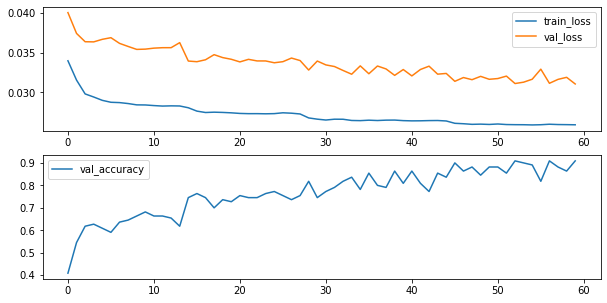

In [ ]:
_, model = train(
  n_epochs=60,
  lr=study.best_params['lr'],
  first_layer_kernel_size=study.best_params['first_layer_kernel_size'],
  dropout_rate=study.best_params['dropout_rate'],
  plot=True,
)

## Show images and their true label-predicted label

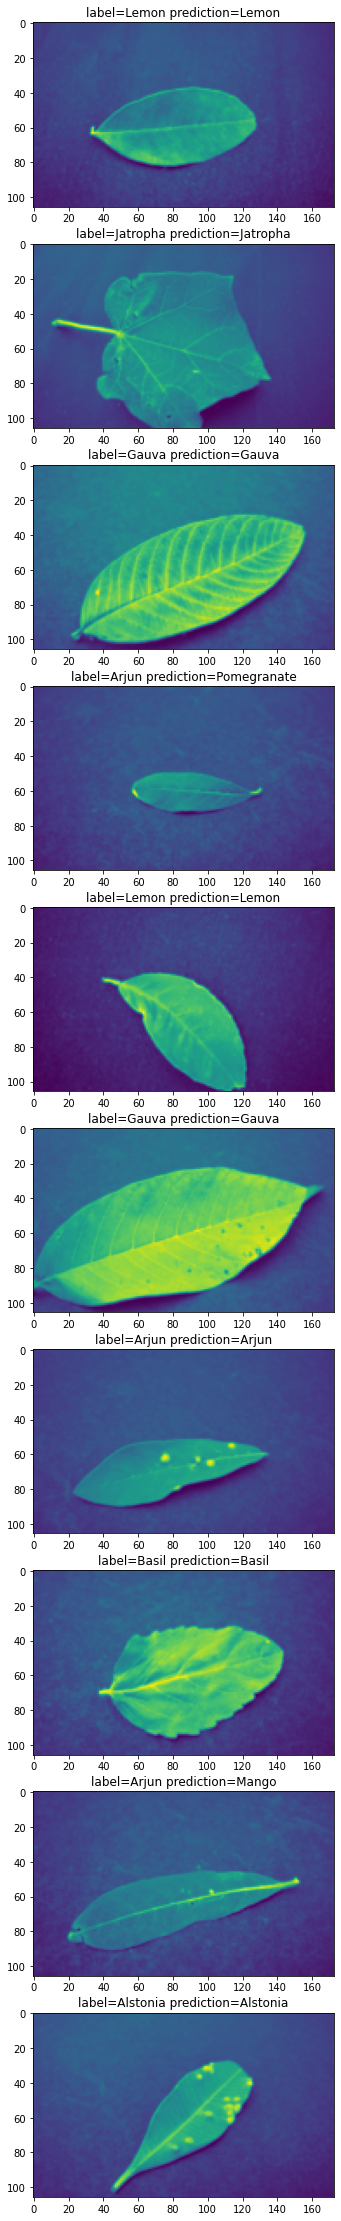

100%|██████████| 2/2 [00:00<00:00, 42.31it/s]

Test loss: 0.0312
Test accuracy: 0.9091


In [ ]:
plt.rcParams['figure.figsize'] = [30,40] # make plots bigger
for (img, label) in dataloaders['test']:
  label = label.to(device)
  batch_size = img.shape[0]
  img = img.to(device)
  img = (img[:, None] / 255).float()
  pred = t.argmax(model(img), dim=1).int()
  fig, axes = plt.subplots(10, 1)
  for i, ax in enumerate(axes):
    cur_pred = pred[i]
    pred_label = unique_labels[cur_pred]
    true_label = unique_labels[label.cpu()[i]]
    ax.imshow(img[i].cpu().permute(1, 2, 0))
    ax.title.set_text(f'label={true_label} prediction={pred_label}')
  plt.show()
  break  

test_loss, test_acc = test_or_valid(
  dataloader=dataloaders['test'],
  model=model) # compute test loss and accuracy

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")